In [12]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
from shapely.geometry import Point, Polygon, box, MultiPolygon
from scipy import ndimage
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
%matplotlib inline

See https://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434

In [3]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet', ax=None, axes=None):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    if ax is not None:
        im = ax.imshow(logheatmap, cmap=cmap, extent=extent)
        ax.invert_yaxis()
        #if axes is not None:
        #    plt.colorbar(im, ax=axes)
        #else:
        #    plt.colorbar(im, ax=ax)
    else:
        plt.imshow(logheatmap, cmap=cmap, extent=extent)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.show()

In [4]:
df = pd.read_pickle('Grantball-20191014T203940-dataframe.pkl')
df['Coordinates'] = list(zip(df.position_long, df.position_lat))
df['Coordinates'] = df['Coordinates'].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry='Coordinates')
#gdf.drop(['position_lat', 'position_long'], axis=1, inplace=True)
gdf.crs = {'init': 'epsg:4326'}   # set coordinate reference system
gdf.head()

,altitude,calories,distance,heart_rate,position_lat,position_long,speed,Coordinates
timestamp,,,,,,,,
2019-10-14 19:39:36,3651.0,0.0,0.00,98.0,53.652700,-1.839835,0.0,POINT (-1.83984 53.65270)
2019-10-14 19:39:37,3651.0,0.0,0.00,99.0,53.652706,-1.839826,0.0,POINT (-1.83983 53.65271)
2019-10-14 19:39:38,3651.0,0.0,1.12,99.0,53.652710,-1.839815,1120.0,POINT (-1.83982 53.65271)
2019-10-14 19:39:39,3651.0,0.0,2.03,99.0,53.652713,-1.839804,910.0,POINT (-1.83980 53.65271)
2019-10-14 19:39:40,3651.0,0.0,2.89,95.0,53.652715,-1.839793,850.0,POINT (-1.83979 53.65272)


In [5]:
gdf_3857 = gdf.to_crs(epsg=3857)
gdf_3857.head()

,altitude,calories,distance,heart_rate,position_lat,position_long,speed,Coordinates
timestamp,,,,,,,,
2019-10-14 19:39:36,3651.0,0.0,0.00,98.0,53.652700,-1.839835,0.0,POINT (-204809.500 7104654.293)
2019-10-14 19:39:37,3651.0,0.0,0.00,99.0,53.652706,-1.839826,0.0,POINT (-204808.492 7104655.427)
2019-10-14 19:39:38,3651.0,0.0,1.12,99.0,53.652710,-1.839815,1120.0,POINT (-204807.270 7104656.167)
2019-10-14 19:39:39,3651.0,0.0,2.03,99.0,53.652713,-1.839804,910.0,POINT (-204806.047 7104656.734)
2019-10-14 19:39:40,3651.0,0.0,2.89,95.0,53.652715,-1.839793,850.0,POINT (-204804.816 7104657.111)


In [6]:
import folium

route_line_4326 = shapely.geometry.LineString(gdf.geometry)
centre_point = route_line_4326.centroid
# Note that folium uses (lat, long) whereas shapely uses (long, lat)
fol_map = folium.Map(location = [centre_point.y, centre_point.x], zoom_start = 17)
folium.GeoJson(route_line_4326).add_to(fol_map)
fol_map

ModuleNotFoundError: No module named 'folium'

In [7]:
points_xy = np.array([(p.x, p.y) for p in gdf_3857.geometry]).T

Kernel density estimate

In [8]:
kde = gaussian_kde(points_xy)

xmin = points_xy[0].min()
xmax = points_xy[0].max()
ymin = points_xy[1].min()
ymax = points_xy[1].max()
X,Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

C:\Users\ellpo\AppData\Local\Continuum\anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


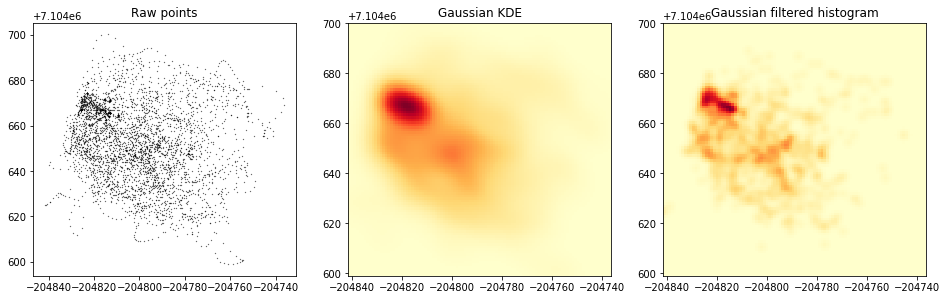

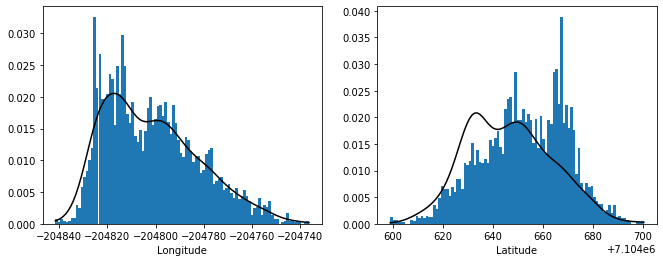

In [19]:
f,ax = plt.subplots(ncols=3, figsize=(16,6))
ax[0].plot(points_xy[0], points_xy[1], 'k.', markersize=.5)
ax[0].set_aspect('equal')
ax[1].imshow(np.rot90(Z), cmap='YlOrRd', extent=[xmin, xmax, ymin, ymax])
heatmap(gdf_3857, ax=ax[2], axes=ax, cmap='YlOrRd')
ax[0].set_title('Raw points')
ax[1].set_title('Gaussian KDE')
ax[2].set_title('Gaussian filtered histogram')
plt.show()

f,ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].hist(points_xy[0], bins=100, density=True)
ax[0].plot(np.linspace(xmin,xmax,100), np.sum(np.rot90(Z), axis=0), 'k')
ax[0].set_xlabel('Longitude')
ax[1].hist(points_xy[1], bins=100, density=True)
ax[1].plot(np.linspace(ymin,ymax,100), np.sum(np.rot90(Z), axis=1), 'k')
ax[1].set_xlabel('Latitude')
plt.show()

### Define pitch

In [29]:
pitch_coords = np.array([[53.652945, -1.839899],
                         [53.652788, -1.839110],
                         [53.652442, -1.839304],
                         [53.652598, -1.840092]])
box1_coords = np.array([[53.652834, -1.839961],
                         [53.652809, -1.839831],
                         [53.652684, -1.839900],
                         [53.652711, -1.840029]])
box2_coords = np.array([[53.652704, -1.839304],
                         [53.652678, -1.839173],
                         [53.652553, -1.839243],
                         [53.652580, -1.839376]])
pitch_coords = pitch_coords[:,::-1]
box1_coords = box1_coords[:,::-1]
box2_coords = box2_coords[:,::-1]

pitch = Polygon([tuple(pt) for pt in pitch_coords])
box1 = Polygon([tuple(pt) for pt in box1_coords])
box2 = Polygon([tuple(pt) for pt in box2_coords])

full_pitch = pd.DataFrame(index=['Pitch', 'box1', 'box2'], columns=['geometry'],
                          data=[pitch, box1, box2])
full_pitch = gpd.GeoDataFrame(full_pitch, geometry='geometry', crs={'init': 'epsg:4326'})
full_pitch = full_pitch.to_crs(epsg=3857)
full_pitch

,geometry
Pitch,"POLYGON ((-204816.620 7104700.311, -204728.789..."
box1,"POLYGON ((-204823.522 7104679.462, -204809.050..."
box2,"POLYGON ((-204750.385 7104655.045, -204735.802..."


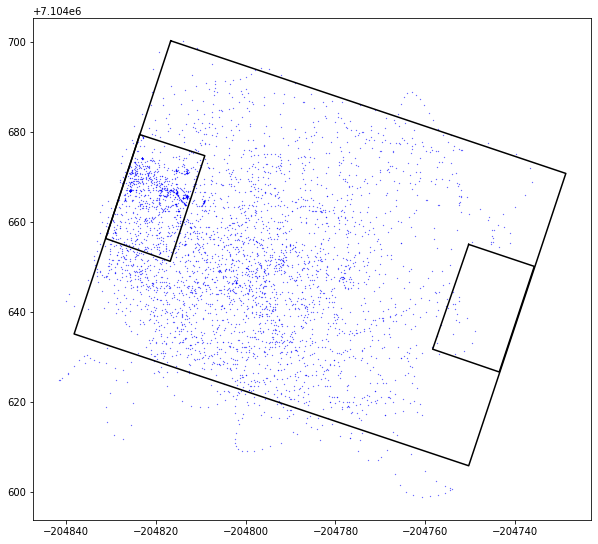

In [30]:
f,ax = plt.subplots(figsize=(10,10))
ax.plot(points_xy[0], points_xy[1], 'b.', markersize=.5)
for i in full_pitch.index:
    ax.plot(*full_pitch.at[i,'geometry'].exterior.xy, c='k')
ax.set_aspect('equal')
plt.show()